In [1]:
using PyPlot
using Distributions

include("utils.jl")

srand(42);

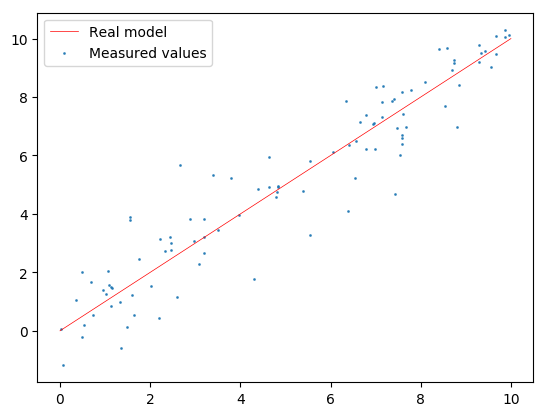

In [12]:
# The goal of this notebook will be to evaluate & implement different algorithms to
# estimate the parameters of a (very simple) linear model from noisy data.
#
# I'm writting this notebook while reading [1] and trying to follow the modeling approached presented
# there.
#
# [1] Estimating Parameters in Physical Models through Bayesian Inversion: A Complete Example

# The first step is to define our parameter-dependent model function together 
# with the real parameter values we will try to estimate.
model = m -> x -> m[1] * x + m[2];
real_parameters = [ 1, 0 ];

# The second step is to generate some *fake* observed data, uniformly sampling 'x' over [0, 10] values
# and adding a (standard) normally distributed error.
N = 100

X = rand(N) * 10

σ = 1
observations = model(real_parameters).(X) + σ*randn(N)

plot([0,10], model(real_parameters).([0,10]), c="red", linewidth=0.5, label="Real model")
scatter(X, observations, s=1, alpha=0.8, label="Measured values")
legend();

In [13]:
# We now encode our prior knowledge into the probability density function for the parameters of our model.
# Here, we will only use the knowledge that both of the parameters lie between -5 and 5 thus
# translating into a uniform distribution over [-5, 5].
# We also assume both parameters to be independently distributed.
prior = dunif2([0 2; 0 2])

# Modulo some normalization factors that we define later, this function evaluates for a given m
# the pdf p(d|m).
likelihood = m ->
    let
        f = model(m) # the materialized model for given parameters
        d = dnorm(0, σ^2) # here, for sake of simplicity, we already know the variance σ^2 of the error

        # as we assume observations are independent, we can evaluate p(d|m) = Πᵢ p(dᵢ|m)
        exp(foldi((i, acc) -> acc + log(d(f(X[i]) - observations[i])), 1, 1:length(X)))
    end

# We can now define the posterior distribution of our model parameter as a normalized product of the
# likelihood and the prio parameters distribution.
to_m = (x,y) -> [x+1 y+1] # transform coordinates from [-1,1]^2 to our prior relevant area [0,2]x[-1, 1]
k = 1/quad2((x, y) -> prior(to_m(x, y))*likelihood(to_m(x, y)))

unnormalized_posterior = m -> prior(m)*likelihood(m)
posterior = m -> k*unnormalized_posterior(m);

### Quadrature

In [14]:
# We can them estimate a value for our parameters by computing the expectation of the posterior using a 2d
# gaussian quadrature of order 3 as described in [2].
#
# [2] http://math2.uncc.edu/~shaodeng/TEACHING/math5172/Lectures/Lect_15.PDF

estimation = quad2((x,y) -> posterior(to_m(x,y)) * to_m(x,y))
variance = quad2((x,y) -> posterior(to_m(x,y)) * (to_m(x,y) - estimation).^2 )

println("a = ", estimation[1], "\t var ≈ 10^", round(log10(variance[1])))
println("b = ", estimation[2], "\t var ≈ 10^", round(log10(variance[2])));

a = 0.9999999999999999	 var ≈ 10^-32.0
b = 0.22540333075851657	 var ≈ 10^-20.0


### Markov Chain Monte Carlo

In [10]:
# Because of the curse of dimensionality, estimating the expectation and variance of the parameters
# in high dimensional spaces will not be efficient anymore using deterministic (right word?) quadrature.
# For this reason (and because it's fun), we will implement a Markov Chain Monte Carlo method to compute
# our integrals of interest.

# Here, we implement the Metropolis-Hastings algorithm as we can easily estimate the joint probability
# (otherwise, Gibbs moves would be the way to go). This approach also allows us to pass the likelihood function
# instead of the normalized joint probability of the parameter space.
function MetropolisHastings(K, Π, γ, x₀)
    X = zeros(K, length(x₀))
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    πₓ = Π(x)
    accepted = 0
    for k=1:K
        y = x + rand(w)
        πₙ = Π(y)
        if rand() < min(1, πₙ / πₓ)
            x = y
            πₓ = πₙ
            accepted += 1
        end
        X[k,:] = x
    end
    X, accepted
end;

In [15]:
# We can then compute the quantities of interest by drawing a large enough sample (how large is large enough?)
# and average the function application of interest on the samples.
samples, n_accepted = MetropolisHastings(10000, unnormalized_posterior, 0.1, rand(2))

estimation = [ mean(samples[:,1]), mean(samples[:,2]) ]
variance = [ mean((samples[:, 1] - estimation[1]).^2), mean((samples[:, 2] - estimation[2]).^2) ]

println("a = ", estimation[1], "\tvar ≈ 10^", round(log10(variance[1])))
println("b = ", estimation[2], "\tvar ≈ 10^", round(log10(variance[2])));

a = 0.9581600459687463	var ≈ 10^-3.0
b = 0.25665433171063384	var ≈ 10^-2.0


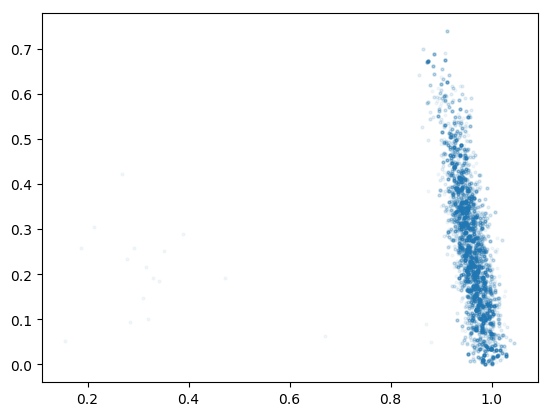

In [16]:
# We can also plot the samples generated by the MCMC to visualize the exploration of
# the parameter space.
scatter(samples[:,1], samples[:,2], s=4, alpha=0.05);

### Sequential Monte Carlo (with MCMC kernels)